In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pickle import dump
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [43]:
def make_data(i, road_name):
    data = pd.read_csv(f"Seoul_2023/Seoul_2023_{i:02d}.csv")
    data['일자'] = pd.to_datetime(data['일자'], format='%Y%m%d')
    data.fillna(0, inplace=True)

    for i in range(24):
        if data[f"{i}시"].dtype!="float":
            data[f"{i}시"] = data[f"{i}시"].map(lambda x: float(str(x).replace(",", "").split()[0]))

    data_weather = pd.read_csv("Seoul_2023/Rain.csv")
    data_weather['날짜'] = pd.to_datetime(data_weather["날짜"])
    data_weather.fillna(0, inplace=True)
    
    data_tem = pd.read_csv("Seoul_2023/Temperature.csv")
    data_tem['날짜'] = pd.to_datetime(data_tem["날짜"])
    data_tem.fillna(0, inplace=True)

    data1 = data[data['지점명']==road_name]
    data_np = np.zeros((data1.shape[0]//2, 3+24*2))
    
    day_to_num = {"일":0, "월":1, "화":2, "수":3, "목":4, "금":5, "토":6}
    
    for i in range(data1.shape[0]//2):
        data_np[i, -3] = day_to_num[data1["요일"].iloc[i]]
        data_np[i, -2] = data_weather[data_weather['날짜']==data1['일자'].iloc[i]]["강수량(mm)"].iloc[0]
        data_np[i, -1] = data_tem[data_tem['날짜']==data1['일자'].iloc[i]]["평균기온(℃)"].iloc[0]
        for j in range(24):
            data_np[i,j] = data1[f"{j}시"].iloc[i]
        for j in range(24):
            data_np[i,j+24] = data1[data1["일자"]==data1["일자"].iloc[i]][f"{j}시"].iloc[1]
    
    return data_np

In [123]:
data_np = []
for i in range(12):
    data_np.append(make_data(i+1, "강남순환로"))
for i in range(12):
    data_np.append(make_data(i+1, "송파대로(송파역)"))
data_np = np.concatenate(data_np)

In [124]:
data_np.shape

(730, 51)

In [102]:
data_crash_pd = pd.read_csv("Seoul_2023/CrashAligned.csv").drop(columns=["Unnamed: 0"])
data_crash_pd.head()

,일자,종로구,마포구,강서구,구로구,영등포구,동작구,관악구,강남구,강동구,...,광진구,강북구,금천구,용산구,성동구,동대문구,성북구,도봉구,은평구,서대문구
0,2023-01-01,0,2,2,0,3,4,3,4,1,...,1,1,2,4,4,5,4,0,3,2
1,2023-01-02,3,1,3,2,4,4,2,5,6,...,3,2,1,0,5,1,0,0,0,1
2,2023-01-03,4,4,2,2,6,2,3,15,1,...,0,3,3,3,2,4,4,3,4,3
3,2023-01-04,6,5,3,1,4,1,1,13,5,...,3,1,4,3,7,4,3,3,3,2
4,2023-01-05,6,2,8,3,3,5,2,13,4,...,3,4,5,8,1,4,4,1,4,0


In [112]:
data_crash = np.concatenate((np.array(data_crash_pd["관악구"]), np.array(data_crash_pd["송파구"])))

In [113]:
data_crash = np.array(data_crash)
data_crash.shape

(730,)

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_np, data_crash, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [126]:
import tensorflow as tf
from tensorflow import keras

In [127]:
model = tf.keras.models.Sequential([
 	tf.keras.layers.Dense(units=128, input_shape=[X_train_scaled.shape[1]]), 
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
  	tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
  	tf.keras.layers.Dense(1)])
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae', 'mse'])

C:\Users\ilese\Downloads\radiosonde data-1 (2)\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 128)                 │           6,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,137 (74.75 KB)

 Trainable params: 19,137 (74.75 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 23.7045 - mae: 3.8423 - mse: 23.7045 - val_loss: 6.0122 - val_mae: 1.8526 - val_mse: 6.0122
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5721 - mae: 2.3197 - mse: 9.5721 - val_loss: 4.6801 - val_mae: 1.6286 - val_mse: 4.6801
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9940 - mae: 1.8751 - mse: 5.9940 - val_loss: 4.8036 - val_mae: 1.6783 - val_mse: 4.8036
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3289 - mae: 2.0656 - mse: 7.3289 - val_loss: 4.5008 - val_mae: 1.6000 - val_mse: 4.5008
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2982 - mae: 2.0253 - mse: 7.2982 - val_loss: 4.6178 - val_mae: 1.6195 - val_mse: 4.6178
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3688 - mae: 2.0214 - mse: 7.3688 - val_loss: 4.4904 - val_mae: 1.6239 - val_mse: 4.4904
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8055 - mae: 1.8376 - mse: 5.8055 - val_loss: 4.5

In [130]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,19.614836,3.384447,19.614836,6.012178,1.852608,6.012178
1,9.728299,2.347677,9.728299,4.680143,1.628552,4.680143
2,6.518001,1.928069,6.518001,4.803643,1.678349,4.803643
3,7.171711,2.018849,7.171711,4.500817,1.600026,4.500817
4,6.701613,1.918382,6.701613,4.617832,1.619537,4.617832


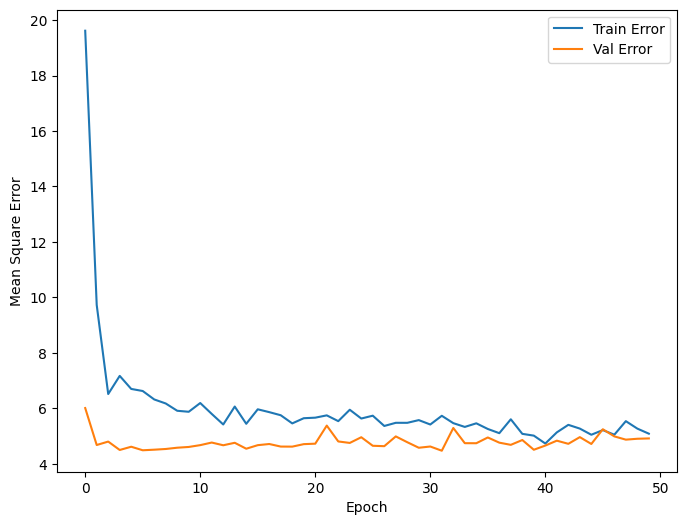

In [135]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,6))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


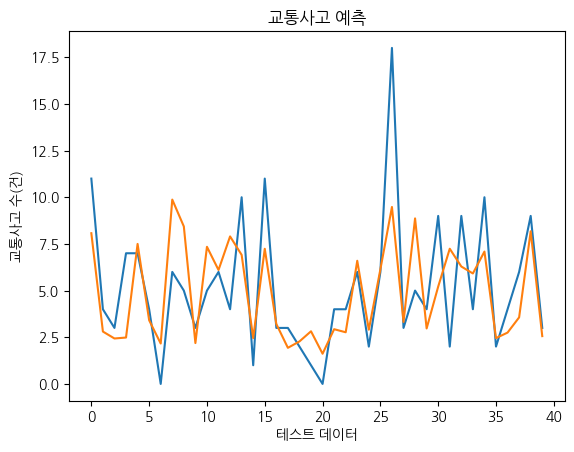

In [140]:
test_predictions = model.predict(X_test_scaled).flatten()
plt.plot(y_test[:40])
plt.plot(test_predictions[:40])
plt.xlabel("테스트 데이터")
plt.ylabel("교통사고 수(건)")
plt.title("교통사고 예측")
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


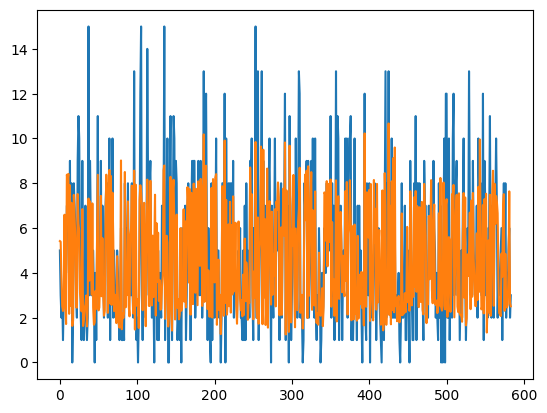

In [133]:
test_predictions = model.predict(X_train_scaled).flatten()
plt.plot(y_train)
plt.plot(test_predictions)
plt.show()